# Entrega laboratorio 6
## Integrantes 

- Javier Steven Barrera Toro - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [2]:
from matplotlib import pyplot as plt
from typing import List, Tuple, NewType
import numpy as np
import pandas as pd
import sympy as sp
import random
import math
import copy
import tabulate
from matplotlib.colors import ListedColormap

np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Problema 1

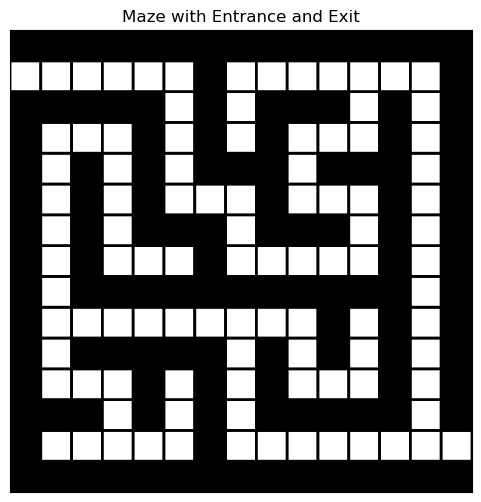

In [3]:
def load_maze(file):
    maze = np.loadtxt(file, dtype=int)
    return maze

def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'black'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()

maze = load_maze('maze_case_base.txt')
display_maze(maze)

In [4]:
maze

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

# Problema 1: Corridor Crawler (laberinto determinístico)

## Representación

Inicialmente se formula utilizar una representación con los posibles movimientos que puede realizar el robot: izquierda, derecha, arriba y abajo. Sin embargo, dada que se había planteado la función de recompensa para que se moviera por el laberinto hasta que se estrellará con una pared se descartaban todas los demás movimientos. Esto provoco que el algoritmo no fuese capaz de aprender a solucionar el laberinto, ya que se descartaban soluciones muy pronto. 

Luego, se planteo una codificación con 3 posibilidades: el robot continua hacía adelante en la orientación actual hasta que se encuentre un cruce con 3 o más bloques libres, o una pared en la siguiente posición, el robot realiza un giro a la derecha y el robot hace un giro a la izquierda.

Tengamos en cuenta que la longitud del gen es mas corta cuando se utiliza la orientación y no todas las posibilidades de movimiento por parte del robot. Dado que la longitud es menor el algoritmo tendrá mas posibilidades de hallar la salida en menos epocas. Algo que nos sucedio al experimentar con la primera aproximación es que el algoritmo en 300 epocas era capaz de solucionar hasta un poco más de la mitad del laberinto. Al reducir la longitud del gen ahora el algoritmo es capaz de llegar a la solución para el caso base con tan solo una longitud del gen de 32 unidades, mientras que si se utilizaba la primera aproximación la longitud minima del gen debía ser de 43 unidades. 

Para lo anterior se propone el siguiente diagrama de clases para realizar la implementación del algoritmo genetico. 

```mermaid
classDiagram
    class Orientation {
        int degrees
        rotate()
        evaluate()
        reset_rotation()
    }

    class GAlgorithm {
        population
        size
        elitism
        individual_length
        sort_population()
        count_reached()
        get_k_best_fitnesses()
        select()
        generate_population()
        display_maze_with_path()
        evolve()
    }

    class ProblemParams {
        maze
        start
        end
        get()
    }

    class Individual {
        steps
        length
        fitness
        reached
        crossover()
        calculate_reward()
        mutate()
    }

    Individual *-- Orientation : composition
    GAlgorithm "1" -- "*" Individual : population
    GAlgorithm ..> ProblemParams : uses
    Individual ..> ProblemParams : uses
```

En la siguiente celda se implementa una función para realizar la visualización de la solución obtenida por el algoritmo genetico. 

In [5]:
def display_maze_with_path(solution, maze, start, end):
        cmap = ListedColormap(['white', 'black', 'royalblue', 'lime', 'gold'])
        maze_display = maze.copy().astype(float)
        rows, cols = maze.shape
    
        if not (0 <= start[0] < rows and 0 <= start[1] < cols and maze[start[0], start[1]] == 0):
            print(f"Advertencia: El punto de inicio {start} no es válido en el laberinto.")
            return
    
        # paths
        def see_paths(i, j, maze):
            empty_paths = 0
            if i + 1 < maze.shape[0] and maze[i + 1, j] == 0: empty_paths += 1
            elif 0 <= i - 1 and maze[i - 1, j] == 0: empty_paths += 1
            elif j + 1 < maze.shape[1] and maze[i, j + 1] == 0: empty_paths += 1
            elif 0 <= j - 1 and maze[i, j - 1] == 0: empty_paths += 1
        
            return empty_paths
    
        path_coords = [start]
        curr = start
        solution.itr_orientation.reset_orientation()
        delta = solution.itr_orientation.evaluate()
        for gen in solution.steps:
            if gen == 0:
                i, j = curr
        
                while (delta[0] + i < maze.shape[0] and delta[1] + j < maze.shape[1]) \
                    and maze[delta[0] + i, delta[1] + j] != 1 and see_paths(i, j, maze) < 3:
                    i, j = (i + delta[0], j + delta[1])
                    path_coords.append((i, j))

                    if (i,j) == end:
                       print("THE SOLUTION REACHED THE END!")
                       break
        
                curr = i, j
            else:
                delta = solution.itr_orientation.rotate(gen)
    
        # mark the path with blue blocks
        path_cells_to_mark = [el for el in path_coords if el != start and el != end]
        for r, c in path_cells_to_mark:
            maze_display[r, c] = 2
    
        # mark the start as green
        if start is not None and 0 <= start[0] < rows and 0 <= start[1] < cols:
            maze_display[start[0], start[1]] = 3
    
        # mark the end as gold
        if end is not None and 0 <= end[0] < rows and 0 <= end[1] < cols:
            maze_display[end[0], end[1]] = 4
    
        # graph
        plt.figure(figsize=(max(8, cols / 2), max(8, rows / 2)))
        norm = plt.cm.colors.BoundaryNorm(np.arange(-0.5, 5.5, 1), cmap.N)
        plt.pcolor(maze_display[::-1], cmap=cmap, edgecolors='k', linewidths=0.5, norm=norm)
    
        plt.title(f"Laberinto con Camino del Individuo")
        plt.gca().set_aspect('equal')
        plt.xticks([])
        plt.yticks([])
        plt.show()
    

En la siguiente celda de código se realiza la implementación `Orientation` y `ProblemParams`.

In [6]:
class Orientation:
    def __init__(self, right: int):
        self.degrees = 0 # 0 degrees
        self.right = right
        self.left = right + 1
        self.movement = {0: (0, 1), 90: (-1, 0), 180: (0, -1), 270: (1, 0)}

    def rotate(self, direction: int):
        if direction not in [self.right, self.left]:
            raise Exception(f"ERROR: DIRECTION NOT FOUND: {direction}")
        if direction == self.right:
            return self.__right_rotation()
            
        return self.__left_rotation()

    def evaluate(self):
        return self.movement.get(self.degrees)

    def reset_orientation(self):
        self.degrees = 0

    def __right_rotation(self):
        self.degrees = (self.degrees + 270) % 360
        return self.movement.get(self.degrees)

    def __left_rotation(self):
        self.degrees = (self.degrees + 90) % 360
        return self.movement.get(self.degrees)

    def __str__(self):
        return str(self.degrees)
    
class ProblemParams:
    def __init__(self, maze, start, end):
        self.maze = maze
        self.start = start
        self.end = end

    def get(self):
        return [self.maze, self.start, self.end]

En la siguiente clase se realiza la implementación del individuo. Un individuo es capaz de realizar el cruce con otro individuo y producir dos hijos, calcular la recompensa del camino escogido y mutar el camino actual. Se implementan otros métodos para facilitar su manejo con la libreria estandar de Python, por ejemplo el método `__str__`.

In [7]:
class Individual:
    def __init__(self, steps, params: ProblemParams):
        self.steps = steps
        self.length = len(steps)
        self.orientation = Orientation(1)
        self.itr_orientation = Orientation(1)
        self.fitness = self.calculate_reward(*params.get())
        self.reached = False
        self.params = params
    
    # problem: 0 0 is also a valid solution if there exists an intersection
    def crossover(self, individual):
        inf = math.ceil(self.length * 0.4)
        sup = math.ceil(self.length * 0.6)
        crosspoint = random.randint(inf, sup)
        steps1, steps2 = [], []
        
        if self.steps[crosspoint] != individual.steps[crosspoint]:
            steps1 = self.steps[:crosspoint] + individual.steps[crosspoint+1:] + [individual.steps[crosspoint]]
            steps2 = individual.steps[:crosspoint] + self.steps[crosspoint+1:] + [self.steps[crosspoint]]
        else:
            steps1 = self.steps[:crosspoint] + individual.steps[crosspoint:]
            steps2 = individual.steps[:crosspoint] + self.steps[crosspoint:]

        i1 = Individual(steps1, self.params)
        i2 = Individual(steps2, self.params)

        return i1, i2

    def calculate_reward(self, maze, origin, end):
        curr = origin
        path = [origin]
        unique = set(origin)
        self.itr_orientation.reset_orientation()
        delta = self.itr_orientation.evaluate()

        def manhattan_distance(p1, p2):
            return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

        def see_paths(i, j, maze):
            empty_paths = 0
            if i + 1 < maze.shape[0] and maze[i + 1, j] == 0: empty_paths += 1
            elif 0 <= i - 1 and maze[i - 1, j] == 0: empty_paths += 1
            elif j + 1 < maze.shape[1] and maze[i, j + 1] == 0: empty_paths += 1
            elif 0 <= j - 1 and maze[i, j - 1] == 0: empty_paths += 1
        
            return empty_paths
        
        fitness = 500
        opposite = {1: 2, 2: 1}
        REACHED = False
        dummie_wall = 0
        dummie_movm = 0
        uniq = 0
        self.reached = False
        
        for index, gen in enumerate(self.steps):
            i, j = curr
            if gen == 0:
                while (delta[0] + i < maze.shape[0] and delta[1] + j < maze.shape[1]) \
                    and see_paths(i, j, maze) < 3:
                    if maze[delta[0] + i, delta[1] + j] == 1:
                        dummie_wall += 1
                        break

                    i, j = (i + delta[0], j + delta[1])
                    path.append((i, j))
                    if (i,j) in unique:
                        uniq -= 1
                    else:
                        unique.add((i,j))
                        uniq += 1

                    if (i,j) == end:
                        REACHED = True
                        self.reached = True
                        break
                curr = i, j
            else:
                delta = self.itr_orientation.rotate(gen)
                if index > 0:
                    if opposite.get(gen) == gen:
                        dummie_movm += 1
                    if [self.steps[i-1], gen, self.steps[i+1]] in [[1, 1, 1], [2, 2, 2]]:
                        dummie_movm += 1

            if REACHED: break

        fitness += uniq * 12 # exploration
        fitness -= manhattan_distance(path[-1], end)*10 # distance
        fitness -= (dummie_movm + dummie_wall) * 15
        fitness += 5000 if REACHED else 0

        return fitness
    
    # mutate to generate solutions like 0 0
    def mutate(self, mutation_rate):
        # change from 1,2 -> 2,1 at least mutation_rate * self.length
        # right shift
        gen_mutate = math.ceil(mutation_rate * self.length)
        for i, gen in enumerate(self.steps):
            if random.random() < mutation_rate:
                if gen != 0:
                    self.steps[i] = random.randint(1,2)
        self.fitness = self.calculate_reward(*self.params.get()) # recalculate the fitness
        return self

    def __str__(self):
        return f"Individual(steps={self.steps}, orientation={self.orientation}, fit={round(self.fitness, 2)})"

    def __repr__(self):
        return self.__str__()

    def __add__(self, other):
        indv = Individual([], self.params)
        indv.fitness = self.fitness + other.fitness
        return indv

    @classmethod
    def zero(cls):
        return Individual([], self.params)
    
    def __radd__(self, other):
        if other == 0:
            return self
        return self.__add__(other)

La siguiente clase es el manejador, se encarga de generar una población base y luego evolucionarla un cierta cantidad de generaciones. Se implementan métodos como `sort_population` para ordenar la población actual, `count_reached` para obtener cuantos individuos alcanzan la salida del laberinto y `get_k_best_fitnesses` obtiene los caminos y la aptitud de los mejores k individuos. 

In [8]:
class GAlgorithm:
    def __init__(self, poblation: int, elitism: float, individual_length: int, mutation_rate: float, generations, params: ProblemParams):
        self.size = poblation
        self.elitism = elitism
        self.length = individual_length
        self.params = params
        self.maze, self.origin, self.goal = self.params.get()
        self.mutation_rate = mutation_rate
        self.generations = generations

        self.__population = None
        self.sorted = False
        self.history = []

    def sort_population(self):
        self.__population = sorted(self.__population, key=lambda ind: ind.fitness, reverse=True)
        self.sorted = True

    def count_reached(self):
        reached = 0
        for indiv in self.__population:
            if indiv.reached:
                reached += 1

        return reached

    def get_k_best_fitnesses(self, k: int):
        subset = self.__population[:k]
        rewards = list(map(lambda s: round(s.fitness, 2), subset))
        paths = list(map(lambda p: p.steps, subset))

        return rewards, paths

    def select(self):
        num_elitist = math.ceil(self.elitism * self.size)
        num_non_elitist = self.size - num_elitist
        
        elitist = self.__population[:num_elitist]
        non_elitist = self.__population[num_elitist:]

        parents = random.sample(non_elitist, k=num_non_elitist)

        # producir los hijos
        offspring = []
        for i in range(0, num_non_elitist):
            indv1, indv2 = random.choices(parents, k=2) # , weights=pr
            rindv1, rindv2 = indv1.crossover(indv2)
            # mutate
            rindv1.mutate(self.mutation_rate)
            rindv2.mutate(self.mutation_rate)
            
            offspring += [rindv1, rindv2]

        self.__population = []
        self.__population = elitist + offspring[:num_non_elitist]
        self.sort_population() # sort the current population
    
    def generate_population(self):
        population = []
        
        for i in range(self.size):
            first_element = random.randint(0,2)
            r = self.length - 1
            indiv = [(random.randint(1,2), 0) for j in range(math.ceil(r/2))] \
                if first_element == 0 \
                else [(0, [1,2][random.randint(0,1)]) for i in range(math.ceil(r/2))]

            steps = [first_element]
            for gen in indiv:
                steps += list(gen)

            diff = len(steps) - self.length
            if diff > 0:
                steps = steps[:len(steps) - diff]

            population.append(Individual(steps, self.params))

        self.__population = population
        self.sort_population() # sort the population

        return self.__population

    def evolve(self) -> Individual:
        if self.__population is None:
            self.__population = self.generate_population()

        print(f"best fitness for the initial population {self.get_k_best_fitnesses(10)[0]}")
        reached = self.count_reached()
        print(f"Rate of reached {reached/self.size:.2f} ({reached}/{self.size})\n")
        
        generation = 1
        best_solution = []
        
        while generation <= self.generations:
            self.select()
            
            if generation % 50 == 0:
                print(f"#### Epoch {generation} ####")
                best, pop = self.get_k_best_fitnesses(10)
                best_solution = best[0], pop[0]
                print(f"10 best fitness {best}")
                reached = self.count_reached()
                print(f"Rate of reached {reached/self.size:.2f} ({reached}/{self.size})\n")

            generation += 1

        print("\n######## BEST SOLUTION ########")
        print(f"\t[->] PATH: {best_solution[1]}")
        print(f"\t[->] REWARD: {best_solution[0]}")

        self.sort_population()
        return self.__population[0]

    def get_population(self):
        return self.__population

El siguiente código se encarga de producir la población con los parámetros dados por parte del enunciado, generar la población inicial y obtener el mejor individuo. 

In [9]:
random.seed(42)
params = ProblemParams(maze, (1,0), (13,14))

alg = GAlgorithm(
    poblation=200,
    elitism=0.02,
    individual_length=32,
    mutation_rate=0.5,
    params=params,
    generations=300
)
population = alg.generate_population()
%time solution = alg.evolve()

best fitness for the initial population [742, 709, 486, 434, 430, 382, 382, 382, 374, 367]
Rate of reached 0.00 (0/200)

#### Epoch 50 ####
10 best fitness [5794, 5794, 5734, 757, 442, 434, 427, 423, 404, 401]
Rate of reached 0.01 (3/200)

#### Epoch 100 ####
10 best fitness [5794, 5794, 5734, 757, 434, 434, 431, 427, 404, 397]
Rate of reached 0.01 (3/200)

#### Epoch 150 ####
10 best fitness [5794, 5794, 5734, 757, 427, 419, 408, 389, 389, 386]
Rate of reached 0.01 (3/200)

#### Epoch 200 ####
10 best fitness [5794, 5794, 5734, 757, 438, 408, 408, 404, 404, 401]
Rate of reached 0.01 (3/200)

#### Epoch 250 ####
10 best fitness [5794, 5794, 5734, 757, 445, 434, 408, 404, 404, 382]
Rate of reached 0.01 (3/200)

#### Epoch 300 ####
10 best fitness [5794, 5794, 5734, 757, 408, 401, 401, 393, 389, 389]
Rate of reached 0.01 (3/200)


######## BEST SOLUTION ########
	[->] PATH: [0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0]
	[->] REWARD: 5794

En cuanto a la convergencia del algoritmo a lo largo de las generaciones se puede ver como a partir de la epoca 50 ya hay 3 individuos que logran alcanzar la salida del laberinto. Estos mismos 3 individuos se mantienen a lo largo de las generaciones. Se debe mencionar la poca capacidad del algoritmo de evolucionar sus poblaciones ya que a partir de la segunda los individuos no son capaces de producir mas soluciones que alcancen el final del laberinto. La mejor solución alcanzada por el algoritmo genetico es la siguiente. 

THE SOLUTION REACHED THE END!


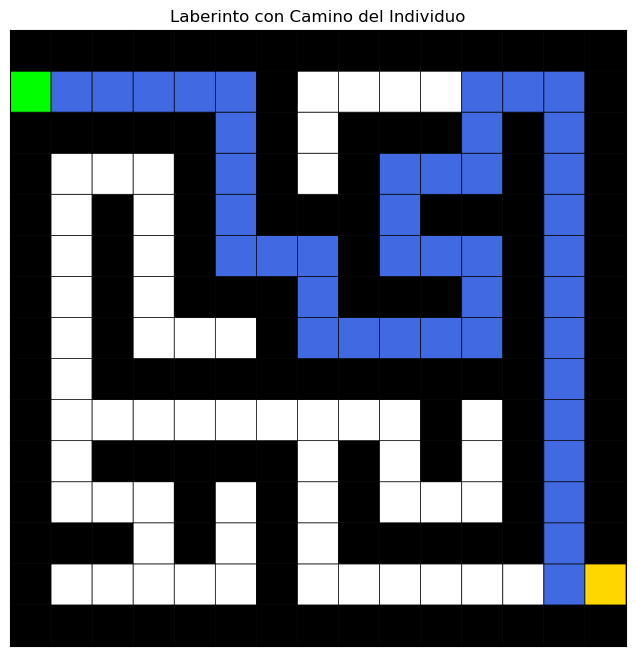

In [10]:
# print(params.get())
display_maze_with_path(solution, *params.get())

## Caso parte 2: laberinto grande

El tamaño del laberinto en este caso es considerablemente mayor al caso anterior. En la siguiente celda de código se realiza la carga del laberinto. 

(51, 51)
[[1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 1]
 [1 1 1 ... 1 0 1]
 ...
 [1 0 1 ... 1 0 1]
 [1 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]]


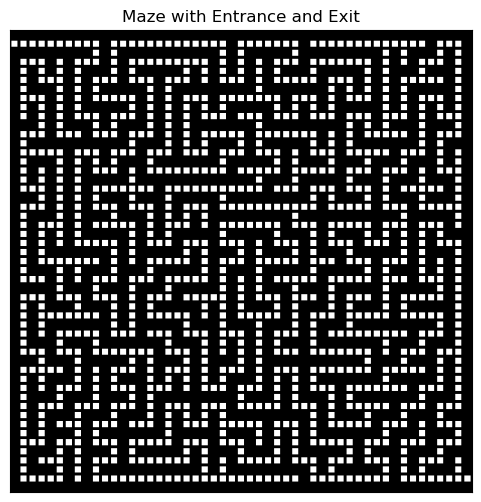

In [11]:
heavy_maze = load_maze('maze_case_heavy.txt')
print(heavy_maze.shape)
print(heavy_maze)
display_maze(heavy_maze)

Y ahora se utiliza el mismo manejador creado para la solución pasada. En este caso surge el problema de que el algoritmo se demora bastante (aproximadamente 5 o 6 minutos) y la evolución de las poblaciones no permite encontrar una solución al laberinto. Debido a lo anterior se plantea utilizar la libreria DEAP (Distributed Evolutionary Algorithms in Python) con el fin de paralelizar algunas partes del proceso, lo cual nos puede ayudar a reducir el tiempo de ejecución. 

In [37]:
params = ProblemParams(maze, (1,0), (13,14))

alg = GAlgorithm(
    poblation=200,
    elitism=0.02,
    individual_length=300,
    mutation_rate=0.5,
    params=ProblemParams(heavy_maze, (1,0), (49, 50)),
    generations=300
)
population = alg.generate_population()
%time solution = alg.evolve()

best fitness for the initial population [-2680, -2836, -3010, -3093, -3115, -3182, -3189, -3344, -3424, -3506]
Rate of reached 0.00 (0/200)

#### Epoch 50 ####
10 best fitness [-1597, -1797, -1948, -1994, -2574, -3176, -3221, -3456, -3532, -3533]
Rate of reached 0.00 (0/200)

#### Epoch 100 ####
10 best fitness [-1597, -1797, -1823, -1913, -2510, -2747, -2854, -2934, -3017, -3120]
Rate of reached 0.00 (0/200)

#### Epoch 150 ####
10 best fitness [-1597, -1797, -1823, -1876, -2442, -2959, -3141, -3247, -3317, -3359]
Rate of reached 0.00 (0/200)

#### Epoch 200 ####
10 best fitness [-1597, -1623, -1690, -1731, -2632, -3077, -3207, -3303, -3309, -3367]
Rate of reached 0.00 (0/200)

#### Epoch 250 ####
10 best fitness [-1597, -1623, -1690, -1731, -2506, -2840, -2902, -2955, -3167, -3172]
Rate of reached 0.00 (0/200)

#### Epoch 300 ####
10 best fitness [-1597, -1615, -1623, -1690, -2657, -2662, -2719, -2775, -2806, -2824]
Rate of reached 0.00 (0/200)


######## BEST SOLUTION ########
	[->]

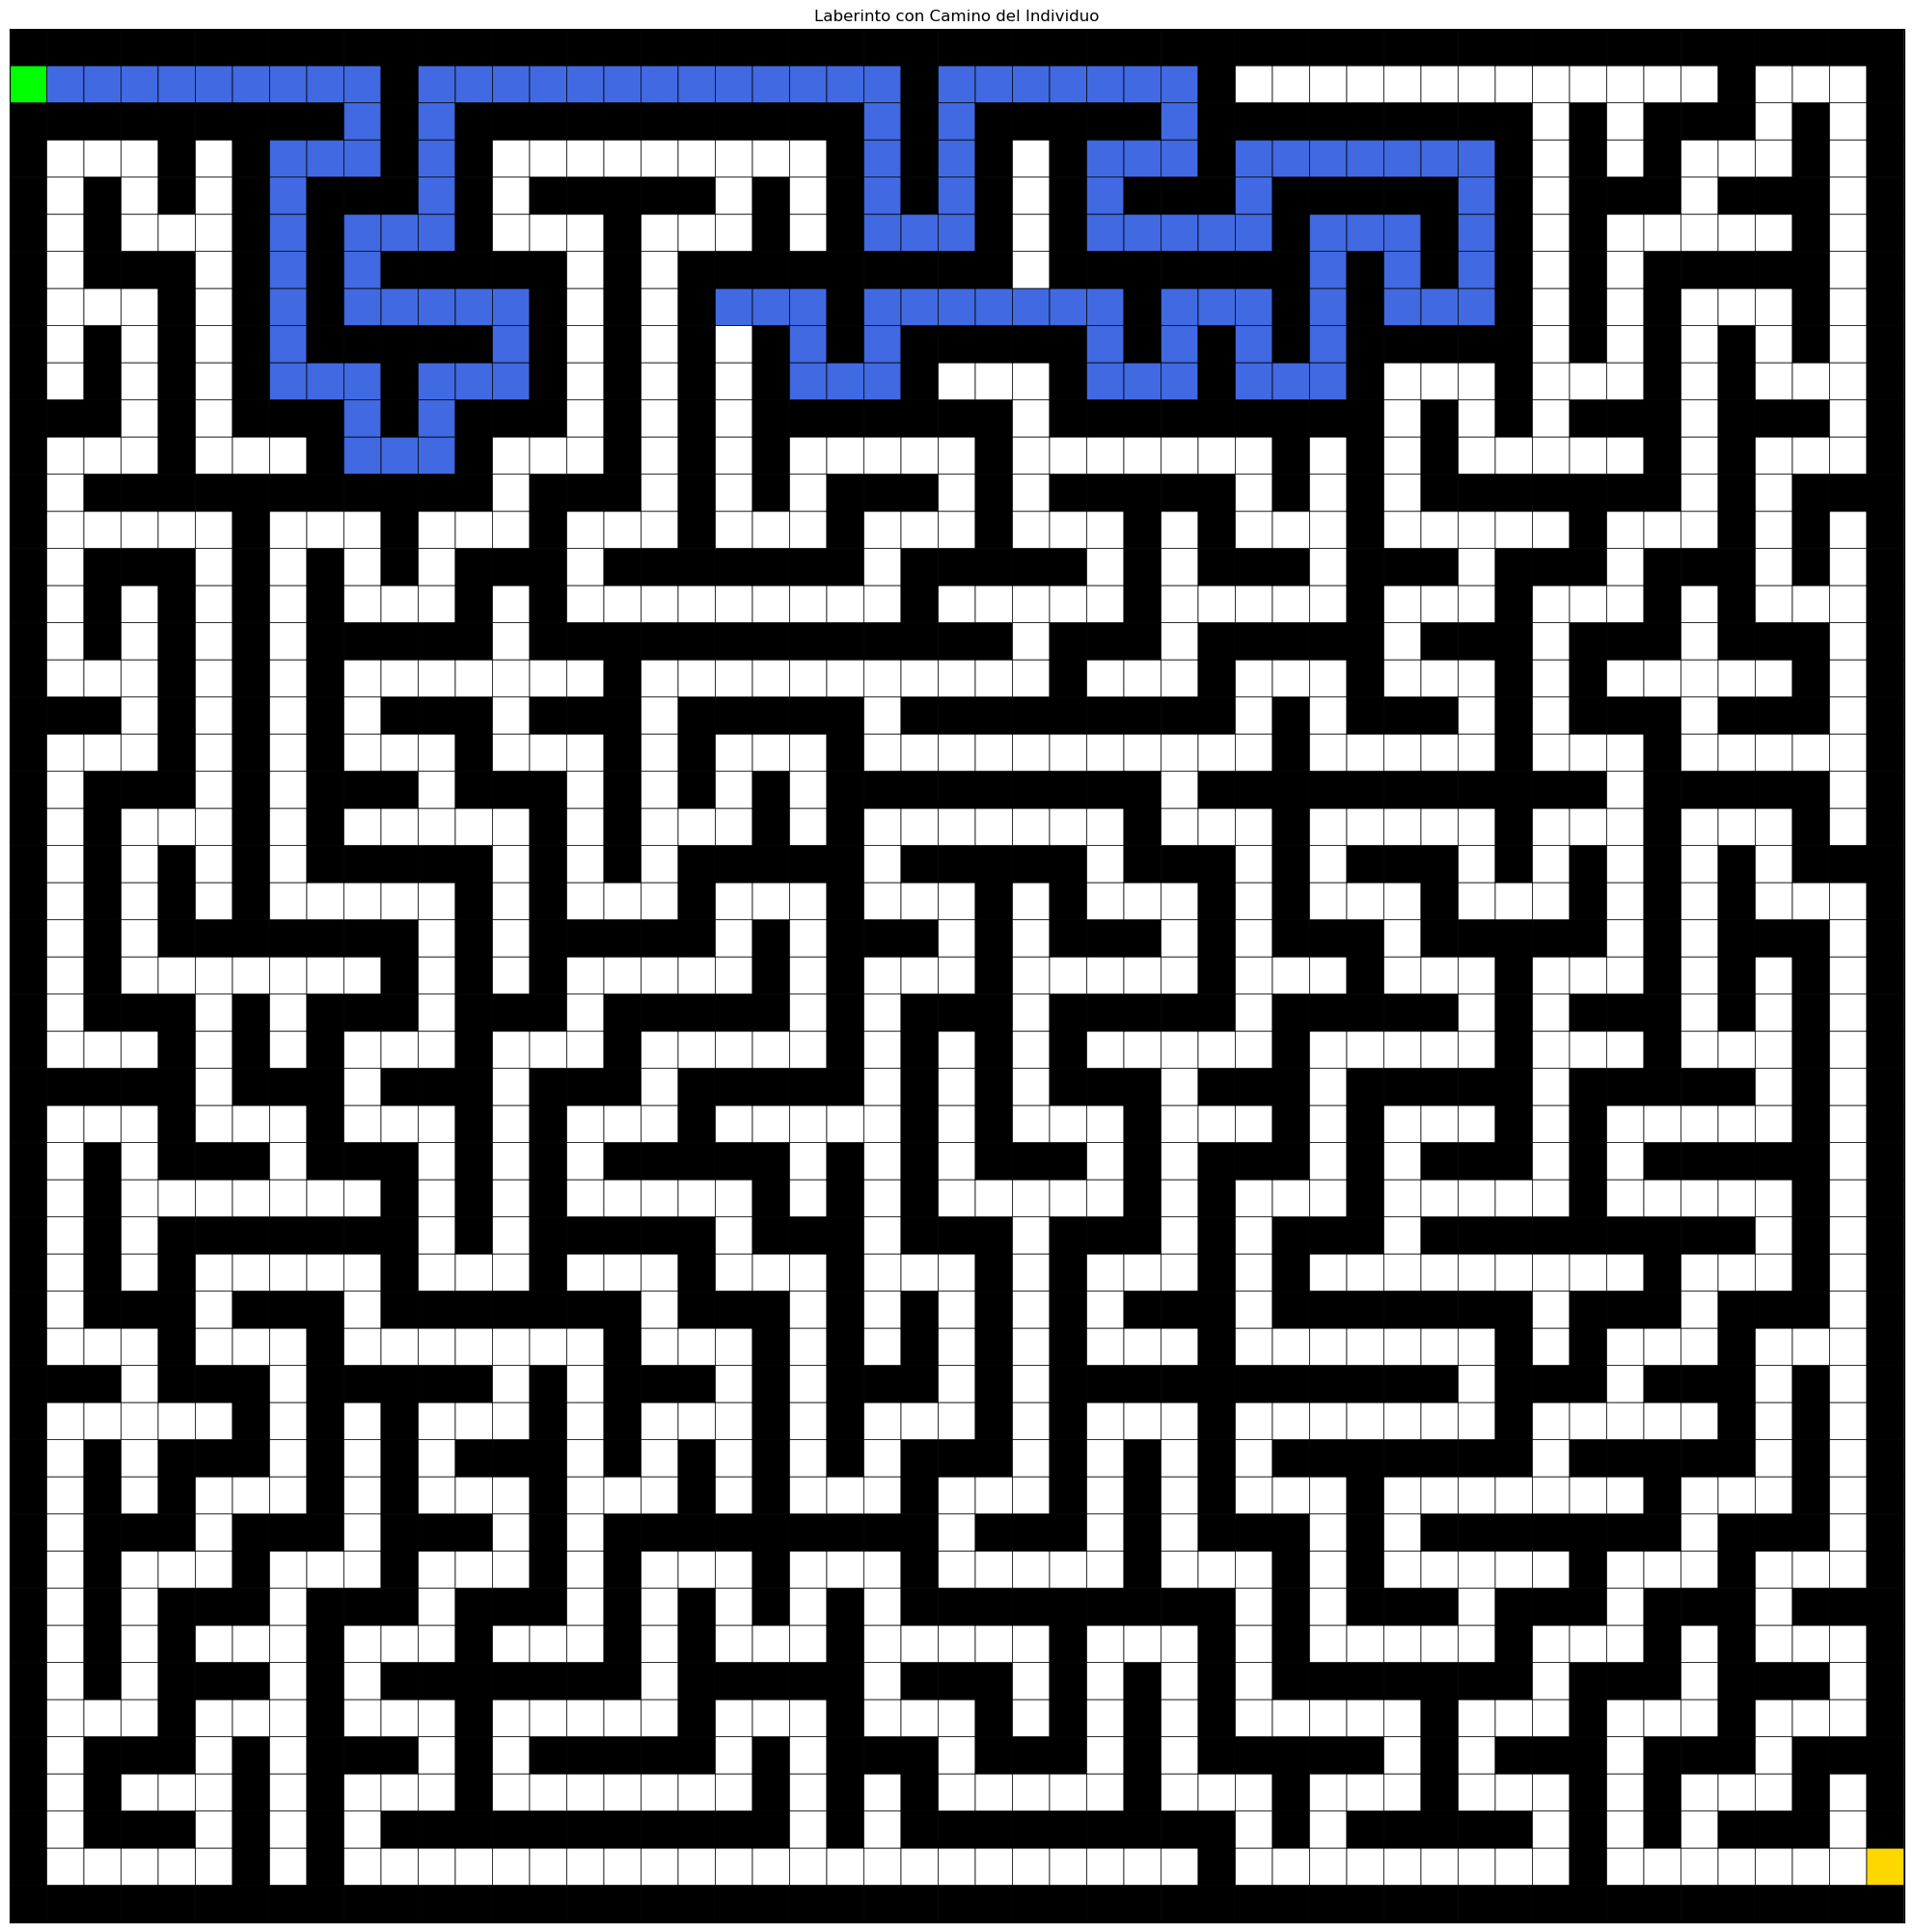

In [39]:
display_maze_with_path(solution.steps, heavy_maze, (1,0), (49,50))

# Usando DEAP

La siguiente es la implementación del caso grande utilizando la libreria DEAP. 

In [14]:
from deap import base, creator
from deap import tools
import multiprocessing

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [15]:
IND_SIZE = 350
toolbox = base.Toolbox()

toolbox.register("attribute", random.randint, 0, 2)
toolbox.register(# individuals are created from random attribute
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attribute,
    n=IND_SIZE
)
# create population from individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [29]:
def evaluate(individual, maze, origin, end):
    individual = individual[0]
    curr = origin
    path = [origin]
    unique = set(origin)
    orientation = Orientation(1)
    delta = orientation.evaluate()

    def manhattan_distance(p1, p2):
        return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

    def see_paths(i, j, maze):
        empty_paths = 0
        if i + 1 < maze.shape[0] and maze[i + 1, j] == 0: empty_paths += 1
        elif 0 <= i - 1 and maze[i - 1, j] == 0: empty_paths += 1
        elif j + 1 < maze.shape[1] and maze[i, j + 1] == 0: empty_paths += 1
        elif 0 <= j - 1 and maze[i, j - 1] == 0: empty_paths += 1
    
        return empty_paths
    
    fitness = 20_000
    opposite = {1: 2, 2: 1}
    REACHED = False
    dummie_wall = 0
    dummie_movm = 0
    uniq = 0
    
    for index, gen in enumerate(individual):
        i, j = curr
        if gen == 0:
            while (delta[0] + i < maze.shape[0] and delta[1] + j < maze.shape[1]) \
                and see_paths(i, j, maze) < 3:
                if maze[delta[0] + i, delta[1] + j] == 1:
                    dummie_wall += 1
                    break

                i, j = (i + delta[0], j + delta[1])
                path.append((i, j))
                if (i,j) in unique:
                    uniq -= 1
                else:
                    unique.add((i,j))
                    uniq += 1

                if (i,j) == end:
                    REACHED = True
                    break
            curr = i, j
        else:
            delta = orientation.rotate(gen)
            if index > 0:
                if opposite.get(gen) == gen:
                    dummie_movm += 1
                if [individual[i-1], gen, individual[i+1]] in [[1, 1, 1], [2, 2, 2]]:
                    dummie_movm += 1

        if REACHED: break

    fitness += uniq * 120 # exploration
    fitness -= manhattan_distance(path[-1], end)*100 # distance
    fitness -= (dummie_movm + dummie_wall) * 150
    fitness += 100_000 if REACHED else 0
    return (fitness,)

In [30]:
toolbox.register("evaluate", evaluate, heavy_maze, (1,0), (49, 50))
toolbox.register("mutate", tools.mutUniformInt, low=0, up=2, indpb=0.05)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("select_elite", tools.selBest)
toolbox.register("select_rest", tools.selTournament, tournsize=5)

In [41]:
def main():
    POPULATION_SIZE = 1000

    print("#### Initializing the first population ####")
    pop = toolbox.population(n=POPULATION_SIZE)
    CXPB, MUTPB, NGEN = 0.7, 0.2, 300

    print("Evaluating the initial population...")
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    num_elite = int(POPULATION_SIZE * 0.02)
    num_non_elite = POPULATION_SIZE - num_elite

    print(f"Starting the Genetic Algorithm with {NGEN} generations")
    print(f"\t[-] Population size: {POPULATION_SIZE}\n\t[-] Elite: {num_elite}")

    for g in range(1, NGEN+1):
        # Select the next generation individuals
        elite_individuals = toolbox.select_elite(pop, k=num_elite)
        elite_individuals = list(map(toolbox.clone, elite_individuals))
        
        parents = toolbox.select_rest(pop, k=num_non_elite)
        offspring = list(map(toolbox.clone, parents))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = elite_individuals + offspring

        fits = [ind.fitness.values[0] for ind in pop]
        length = len(pop)
        mean = sum(fits) / length
        std = abs(sum(x * x for x in fits) / length - mean ** 2)**0.5
        if g % 50 == 0 or g == 1 or g == NGEN:
            print(f"-------- EPOCH {g} --------")
            print(f"\t-> Min fitness: {min(fits):.2f}")
            print(f"\t-> Max fitness: {max(fits):.2f}")
            print(f"\t-> Mean: {mean:.2f}")
            print(f"\t-> Std dev: {std:.2f}")

    return pop

if __name__ == '__main__':
    %time population = main()
    result = tools.selBest(population, 1)[0]

#### Initializing the first population ####
Evaluating the initial population...
Starting the Genetic Algorithm with 300 generations
	[-] Population size: 1000
	[-] Elite: 20
-------- EPOCH 1 --------
	-> Min fitness: 2600.00
	-> Max fitness: 3000.00
	-> Mean: 2928.00
	-> Std dev: 75.47
-------- EPOCH 50 --------
	-> Min fitness: 2800.00
	-> Max fitness: 3000.00
	-> Mean: 2997.40
	-> Std dev: 21.29
-------- EPOCH 100 --------
	-> Min fitness: 2900.00
	-> Max fitness: 3000.00
	-> Mean: 2999.40
	-> Std dev: 7.72
-------- EPOCH 150 --------
	-> Min fitness: 2800.00
	-> Max fitness: 3000.00
	-> Mean: 2998.20
	-> Std dev: 17.23
-------- EPOCH 200 --------
	-> Min fitness: 2800.00
	-> Max fitness: 3000.00
	-> Mean: 2997.10
	-> Std dev: 21.01
-------- EPOCH 250 --------
	-> Min fitness: 2800.00
	-> Max fitness: 3000.00
	-> Mean: 2997.60
	-> Std dev: 19.86
-------- EPOCH 300 --------
	-> Min fitness: 2600.00
	-> Max fitness: 3000.00
	-> Mean: 2998.30
	-> Std dev: 18.63
CPU times: total: 2min 2

[2, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 1, 2, 0, 2, 1, 2, 1, 1, 2, 0, 0, 2, 0, 1, 1, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 2, 0, 2, 1, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 0, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 2, 2, 0, 0, 2, 1, 2, 0, 1, 1, 1, 1, 2, 

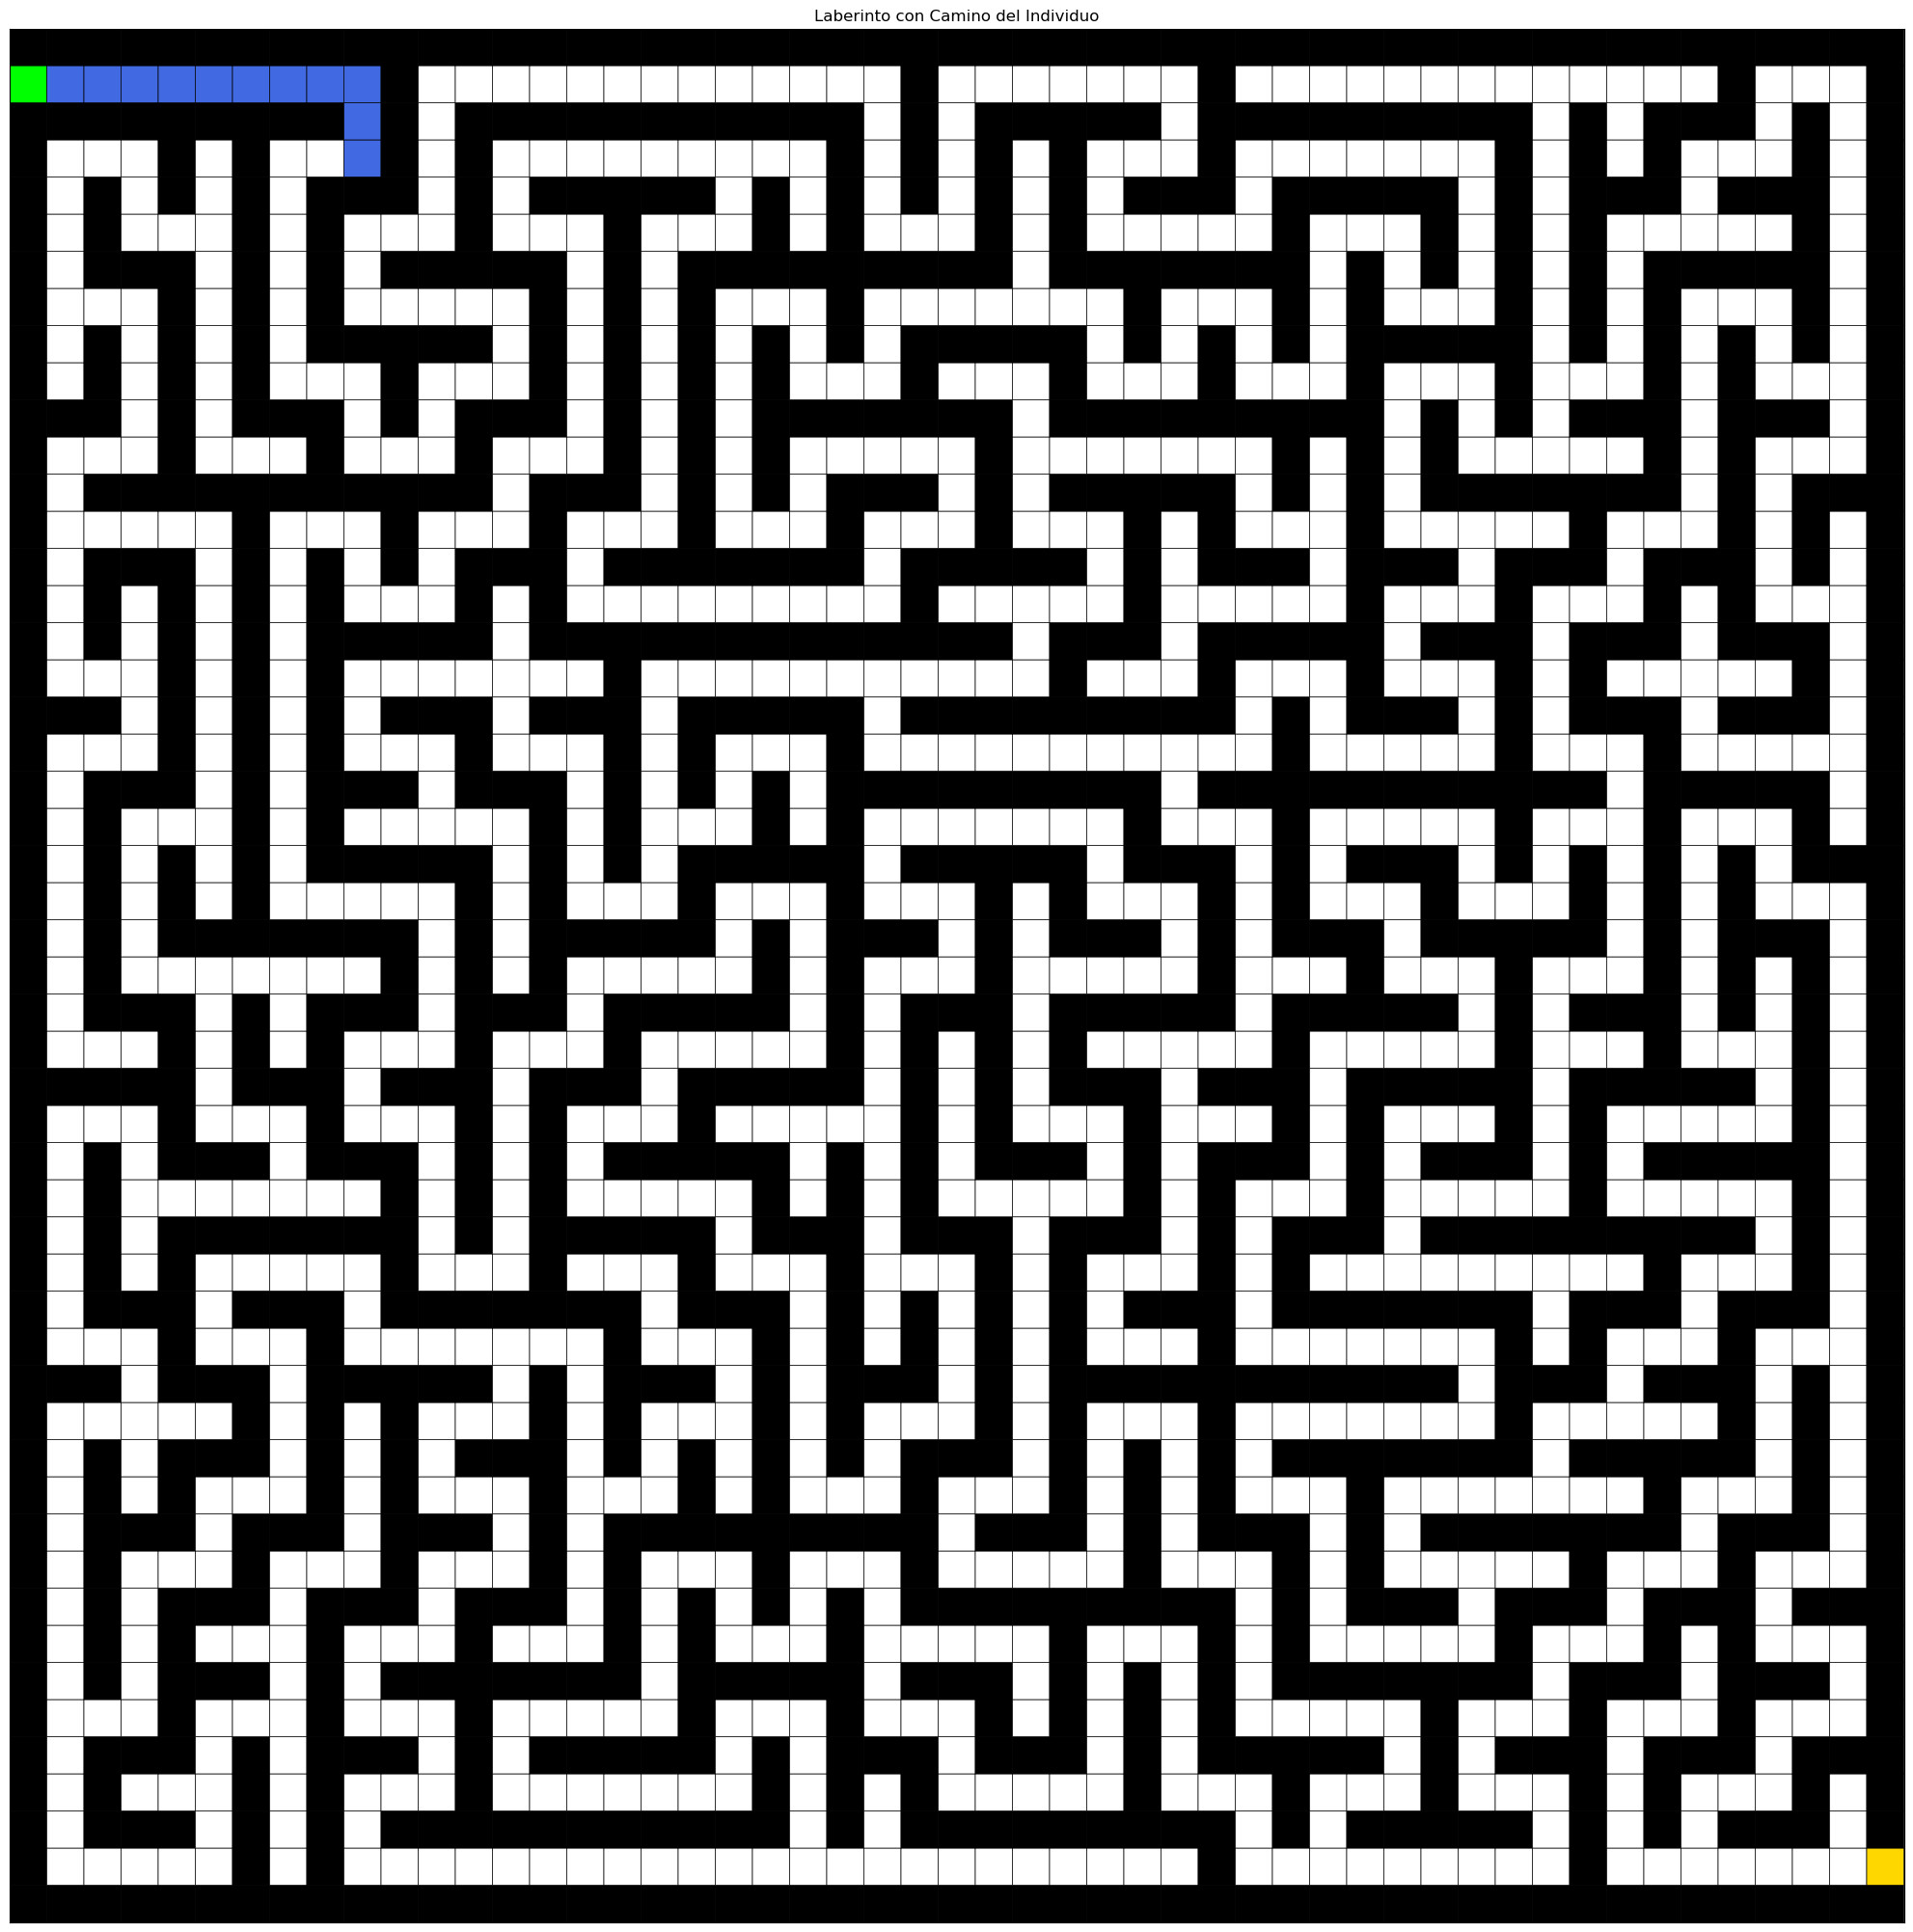

In [42]:
result = tools.selBest(population, 1)[0]
print(result)

def display_maze_with_path(solution, maze, start, end):
    cmap = ListedColormap(['white', 'black', 'royalblue', 'lime', 'gold'])
    maze_display = maze.copy().astype(float)
    rows, cols = maze.shape

    if not (0 <= start[0] < rows and 0 <= start[1] < cols and maze[start[0], start[1]] == 0):
        print(f"Advertencia: El punto de inicio {start} no es válido en el laberinto.")
        return

    # paths
    def see_paths(i, j, maze):
        empty_paths = 0
        if i + 1 < maze.shape[0] and maze[i + 1, j] == 0: empty_paths += 1
        elif 0 <= i - 1 and maze[i - 1, j] == 0: empty_paths += 1
        elif j + 1 < maze.shape[1] and maze[i, j + 1] == 0: empty_paths += 1
        elif 0 <= j - 1 and maze[i, j - 1] == 0: empty_paths += 1
    
        return empty_paths

    path_coords = [start]
    curr = start
    orientation = Orientation(1)
    delta = orientation.evaluate()
    for gen in solution:
        if gen == 0:
            i, j = curr
    
            while (delta[0] + i < maze.shape[0] and delta[1] + j < maze.shape[1]) \
                and maze[delta[0] + i, delta[1] + j] != 1 and see_paths(i, j, maze) < 3:
                i, j = (i + delta[0], j + delta[1])
                path_coords.append((i, j))
    
                if (i,j) == end:
                   print("THE SOLUTION REACHED THE END!")
                   break
    
            curr = i, j
        else:
            delta = orientation.rotate(gen)

    # mark the path with blue blocks
    path_cells_to_mark = [el for el in path_coords if el != start and el != end]
    for r, c in path_cells_to_mark:
        maze_display[r, c] = 2

    # mark the start as green
    if start is not None and 0 <= start[0] < rows and 0 <= start[1] < cols:
        maze_display[start[0], start[1]] = 3

    # mark the end as gold
    if end is not None and 0 <= end[0] < rows and 0 <= end[1] < cols:
        maze_display[end[0], end[1]] = 4

    # graph
    plt.figure(figsize=(max(8, cols / 2), max(8, rows / 2)))
    norm = plt.cm.colors.BoundaryNorm(np.arange(-0.5, 5.5, 1), cmap.N)
    plt.pcolor(maze_display[::-1], cmap=cmap, edgecolors='k', linewidths=0.5, norm=norm)

    plt.title(f"Laberinto con Camino del Individuo")
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.show()

display_maze_with_path(result, heavy_maze, (1,0), (49,50))

Bien se puede ver como a pesar de que el número de individuos por población es bastante grande no se logra alcanzar la salida del laberinto. Esto se puede deber principalmente a la forma en la que se represento el individuo y a la función de aptitud que se implemento. Tampoco se puede ver una mejora entre generaciones, es decir, se puede ver que el max y el min de todas las aptitudes por generación no mejora. También es necesario mencionar como la desviación estandar inicia alta, pero luego se reduce y no incrementa considerablemente. Esto nos indica que a lo largo de las poblaciones no hay mayor variación entre los individuos, casi como si se estuviera homogenizando la población. 

## Conclusiones (DEAP vs implementación)

Al utilizar DEAP, muy posiblemente por la representación del gen y la función de aptitud, no se fue capaz de alcanzar la salida del laberinto. Además, la implementación realizada tomaba ventaja de ciertos detalles que no hace DEAP. Por ejemplo, se sabe que hay dos tipos de soluciones para los laberintos, aquellos cuya posición inicial garantiza que se mueva hacía la solución y aquellos en los cuales tiene que girar hacía un lado para llegar a la solución. Por lo anterior, sabiendo que los laberintos inicialmente tienen via libre hacía la derecha, entonces se priorizan las soluciones al crear y mutar con `0` en su posición inicial, ya que solo tienen que desplazarse a la derecha. Esto en conjunto con algunas otras cosas que se realizan para que el algoritmo sea capaz de hallar una solución.

Sobre quien podría encontrar primero la salida seguramente con bastante tiempo y un número considerable de individuos se podría llegar eventualmente a la salida con la implementación hecha por nosotros. El único problema es que los individuos en la población se tienden a parecer, entonces si por ejemplo se deja corriendo durante 1 hora, las soluciones inicialmente planteadas empezarían a converger y no mejorar. En este caso tendría que implementarse una función de evolución y mutación distinta. 

Algunos puntos de mejora podrían ser implementar distintas codificaciones de los individuos para probar la libreria DEAP, como por ejemplo, la codificación de los 4 posibles movimientos. En cuanto a la implementación propiamente hecha para realizar el caso base se puede mejorar el código, actualmente hay algunas cosas que se encuentran hardcodeadas. 